### Цель: 
Спрогнозировать ежедневные продажи магазинов, используя историю продаж и информацию о магазинах, акциях, праздниках и других факторах.

• train.csv — продажи по магазинам по дням: Store, Date, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday \
• store.csv — характеристики магазинов: StoreType, Assortment, CompetitionOpenSince, Promo2, PromoInterval и т.д.

In [72]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


In [13]:
df_train = pd.read_csv('train_ros.csv', parse_dates=["Date"], low_memory=False)
df_store = pd.read_csv('store_ros.csv')


df_test = pd.read_csv('test_ros.csv')

In [17]:
df_train.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [16]:
df_store.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [18]:
df_train.shape

(1017209, 9)

In [21]:
df_store.shape

(1115, 10)

In [19]:
df = df_train.merge(df_store, on = 'Store', how='left')

In [20]:
df.shape

(1017209, 18)

In [22]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [27]:
df.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

In [30]:
df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [31]:
df['CompetitionDistance'].fillna(0, inplace=True)
df['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
df['CompetitionOpenSinceYear'].fillna(0, inplace=True)
df['Promo2SinceWeek'].fillna(0, inplace=True)
df['Promo2SinceYear'].fillna(0, inplace=True)
df['PromoInterval'].fillna(0, inplace=True)

In [32]:
df.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [34]:
# Добавление новых фичей к нашему df

In [37]:
df_festures.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,year
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,2015


In [53]:
df_festures = df.copy()

In [54]:
df_festures['year'] = df_festures['Date'].dt.year
df_festures['month'] = df_festures['Date'].dt.month
df_festures['day'] = df_festures['Date'].dt.day
df_festures['weekday'] = df_festures['Date'].dt.weekday

In [56]:
df_festures['is_weekend'] = (df_festures['weekday'] >= 5).astype(int)
df_festures['is_holiday'] = (df_festures['StateHoliday'] != '0').astype(int)

In [57]:
df_festures = df_festures.sort_values(['Store', 'Date'])

df_festures['sales_lag_1'] = df_festures.groupby('Store')['Sales'].shift(1)
df_festures['sales_lag_7'] = df_festures.groupby('Store')['Sales'].shift(7)
df_festures['sales_lag_14'] = df_festures.groupby('Store')['Sales'].shift(14)

In [58]:
df_festures['rolling_mean_7'] = df_festures.groupby('Store')['Sales'].shift(1).rolling(7).mean().reset_index(0, drop=True)
df_festures['rolling_std_7'] = df_festures.groupby('Store')['Sales'].shift(1).rolling(7).std().reset_index(0, drop=True)

In [59]:
df_festures['promo_active'] = df_festures['Promo'].astype(int)

In [60]:
df_festures.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,day,weekday,is_weekend,is_holiday,sales_lag_1,sales_lag_7,sales_lag_14,rolling_mean_7,rolling_std_7,promo_active
1016095,1,2,2013-01-01,0,0,0,0,a,1,c,...,1,1,0,1,NaN,NaN,NaN,17755.714286,7984.395671,0
1014980,1,3,2013-01-02,5530,668,1,0,0,1,c,...,2,2,0,0,0.0,NaN,NaN,5423.714286,2543.763138,0
1013865,1,4,2013-01-03,4327,578,1,0,0,1,c,...,3,3,0,0,5530.0,NaN,NaN,6553.285714,3038.425783,0
1012750,1,5,2013-01-04,4486,619,1,0,0,1,c,...,4,4,0,0,4327.0,NaN,NaN,3686.142857,1753.531620,0
1011635,1,6,2013-01-05,4997,635,1,0,0,1,c,...,5,5,1,0,4486.0,NaN,NaN,3584.285714,1967.006415,0


In [61]:
df_model = df_festures.dropna(subset=['sales_lag_1', 'rolling_mean_7'])

In [68]:
df_model.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'year', 'month', 'day', 'weekday',
       'is_weekend', 'is_holiday', 'sales_lag_1', 'sales_lag_7',
       'sales_lag_14', 'rolling_mean_7', 'rolling_std_7', 'promo_active'],
      dtype='object')

0:	learn: 3550.6397154	total: 28.5ms	remaining: 28.5s
100:	learn: 998.0621629	total: 1.81s	remaining: 16.1s
200:	learn: 915.0764013	total: 3.6s	remaining: 14.3s
300:	learn: 878.6700156	total: 5.34s	remaining: 12.4s
400:	learn: 856.4443293	total: 7.1s	remaining: 10.6s
500:	learn: 842.5620883	total: 8.85s	remaining: 8.82s
600:	learn: 831.7588673	total: 10.6s	remaining: 7.03s
700:	learn: 823.4157406	total: 12.3s	remaining: 5.26s
800:	learn: 816.2735431	total: 14.1s	remaining: 3.49s
900:	learn: 810.2035605	total: 15.8s	remaining: 1.74s
999:	learn: 804.6065381	total: 17.6s	remaining: 0us
RMSE: 1025.75
MAE: 612.97


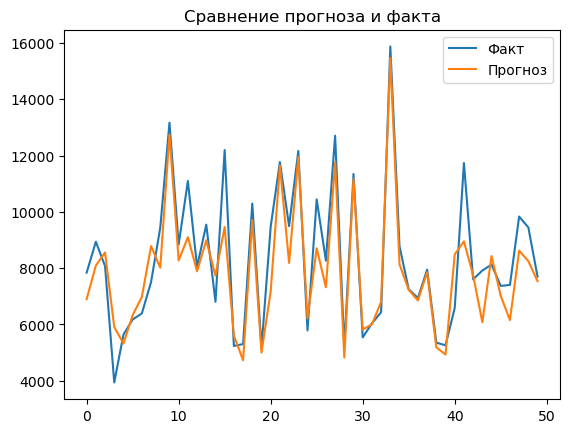

In [75]:
# Train/test split по времени
df_model = df_model.sort_values('Date')
split_date = df_model['Date'].quantile(0.8)
train_df = df_model[df_model['Date'] < split_date]
test_df = df_model[df_model['Date'] >= split_date]

# Обучение
features = ['Store', 'Promo', 'year', 'month', 'day', 'weekday',
            'is_weekend', 'is_holiday', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14',
            'rolling_mean_7', 'rolling_std_7', 'promo_active']
target = 'Sales'

model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', verbose=100)
model.fit(train_df[features], train_df[target])

# Прогноз и метрики
y_pred = model.predict(test_df[features])
rmse = mean_squared_error(test_df[target], y_pred, squared=False)
mae = mean_absolute_error(test_df[target], y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# График
plt.plot(test_df[target].values[:50], label="Факт")
plt.plot(y_pred[:50], label="Прогноз")
plt.legend()
plt.title("Сравнение прогноза и факта")
plt.show()